#Earthquake Mapping
This notebook is adapted from Wes Mckinley's Python for Data Analysis.

The project is an application of earthquake mapping in Haiti, utilizing the dataset published at ushadidi.

In [1]:
!pip install basemap basemap-data-hires


In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Let's import the dataset for the earthquake data and for geological data.

In [3]:
dataset_url = "https://raw.githubusercontent.com/wesm/pydata-book/3rd-edition/datasets/haiti/Haiti.csv"
!wget -O haiti.csv {dataset_url}
data = pd.read_csv("haiti.csv")

data = data[(data.LATITUDE>18) & (data.LATITUDE<20) & (data.LONGITUDE>-75) & (data.LONGITUDE <-70) & data.CATEGORY.notnull()]

--2024-05-23 09:51:23--  https://raw.githubusercontent.com/wesm/pydata-book/3rd-edition/datasets/haiti/Haiti.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1951984 (1.9M) [text/plain]
Saving to: ‘haiti.csv’

haiti.csv           100%[===================>]   1.86M  --.-KB/s    in 0.07s   

2024-05-23 09:51:24 (26.1 MB/s) - ‘haiti.csv’ saved [1951984/1951984]



In [4]:
!git clone https://github.com/wesm/pydata-book.git
repo_path = "/content/pydata-book/datasets/haiti/PortAuPrince_Roads"

fatal: destination path 'pydata-book' already exists and is not an empty directory.


We define the functions below to process the data.

to_cat_list function takes a string of comma-separated categories and returns a list of cleaned-up category strings.

get_all_categories function takes a series of category strings and returns a sorted list of unique categories.

get_english function takes a category string and returns a tuple of the category code and the corresponding English category name.

get_code function takes a list of category strings and returns a list of category codes.

basic_haiti_map function creates a Basemap instance with a specified bounding box and draws the map of the desired location.

In the cell after, we will use the functions and create a map of earthquakes in the region.

In [5]:
def to_cat_list(catstr):
    stripped = (x.strip() for x in catstr.split(','))
    return [x for x in stripped if x]

def get_all_categories(cat_series):
    cat_sets = (set(to_cat_list(x)) for x in cat_series)
    return sorted(set.union(*cat_sets))

def get_english(cat):
    code, names = cat.split('.')
    if '|' in names:
        names = names.split('|')[1]
    return code,names.strip()

def get_code(seq):
    return [x.split('.')[0] for x in seq if x]

def basic_haiti_map(ax=None, lllat = 17.25, urlat=20.25,lllon=-75,urlon=-71):
    m =Basemap(ax=ax,projection='stere',
                lon_0=(urlon+lllon)/2, lat_0 = (urlat + lllat)/2,
                llcrnrlat = lllat, urcrnrlat =urlat,
                llcrnrlon=lllon, urcrnrlon=urlon,
                resolution = 'i')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    return m

In [6]:
#Map category codes to English
all_cats = get_all_categories(data.CATEGORY)
english_mapping = dict(get_english(x) for x in all_cats)

#Create a new DataFrame dummy_frame with columns corresponding to each unique category code.

all_codes = get_code(all_cats)
code_index = pd.Index(np.unique(all_codes))
dummy_frame = DataFrame(np.zeros((len(data), len(code_index))), index=data.index, columns=code_index)

#Loop through each row of the original DataFrame and set the corresponding category code columns to 1 in the dummy_frame.
for row, cat in zip(data.index, data.CATEGORY):
    codes = get_code(to_cat_list(cat))
    dummy_frame.loc[row,codes] =1

#Join the dummy_frame with the original DataFrame to create a new DataFrame with category code columns
data = data.join(dummy_frame.add_prefix('category'))
print(data)

      Serial                                     INCIDENT TITLE  \
0       4052  * URGENT * Type O blood donations needed in #J...   
4       4042                                 Citi Soleil school   
5       4041                           Radio Commerce in Sarthe   
6       4040                   Contaminated water in Baraderes.   
7       4039     Violence at &quot;arcahaie bas Saint-Ard&quot;   
...      ...                                                ...   
3588       8                         Canape Vert road destroyed   
3589       7               Collapsed Building -- People Trapped   
3590       6             Eye-Witness Report from Hotel Oloffson   
3591       5  Port-au-Prince air traffic control tower damag...   
3592       4                            National Palace damaged   

         INCIDENT DATE                                           LOCATION  \
0     05/07/2010 17:26                                      Jacmel, Haiti   
4     18/05/2010 16:26                   

Now, we have our dataset the way required. We can plot the map.

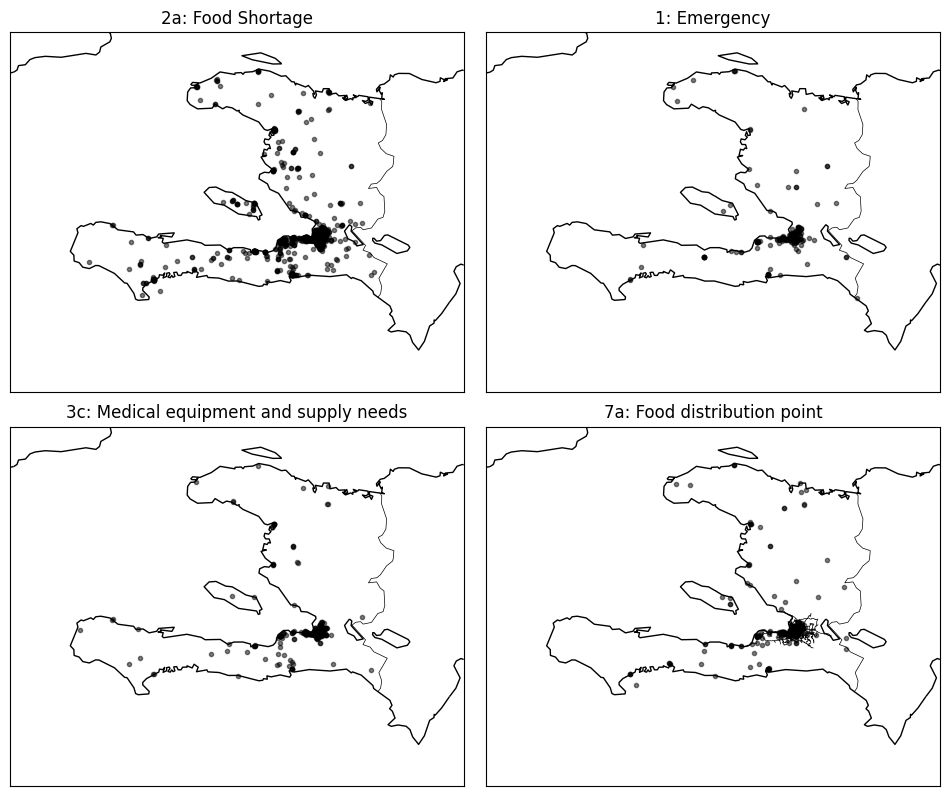

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
fig.subplots_adjust(hspace=0.05,wspace=0.05)
to_plot =['2a','1','3c','7a']

lllat =17.25 ; urlat = 20.25 ; lllon = -75 ; urlon = -71

for code, ax in zip(to_plot, axes.flat):
    m = basic_haiti_map(ax, lllat=lllat, urlat = urlat, lllon=lllon, urlon=urlon)
    cat_data = data[data['category%s' %code] == 1]

    x, y = m(cat_data.LONGITUDE, cat_data.LATITUDE)
    m.plot(x,y,'k.',alpha = 0.5)
    ax.set_title('%s: %s'%(code,english_mapping[code]))

shapefile_path = '/content/pydata-book/datasets/haiti/PortAuPrince_Roads/PortAuPrince_Roads'
m.readshapefile(shapefile_path, 'roads')

plt.show()